In [ ]:
!pip install contractions
!pip install datasets
!pip install pytorch_lightning
!pip install transformers

import tensorflow as tf
import torch

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

import pandas as pd
import numpy as np
import re
import string
import math
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download("stopwords")
nltk.download("wordnet")

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from torchmetrics.functional import accuracy, f1_score, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

from pylab import rcParams
from matplotlib import rc
import seaborn as sns
import matplotlib.pyplot as plt
import os



%matplotlib inline
%config InlineBackend.figure_format='retina'

     |████████████████████████████████| 106 kB 5.4 MB/s 
     |████████████████████████████████| 287 kB 39.1 MB/s 
     |████████████████████████████████| 325 kB 5.4 MB/s 
     |████████████████████████████████| 1.1 MB 41.7 MB/s 
     |████████████████████████████████| 212 kB 44.8 MB/s 
     |████████████████████████████████| 77 kB 6.3 MB/s 
     |████████████████████████████████| 136 kB 43.7 MB/s 
     |████████████████████████████████| 127 kB 41.9 MB/s 
     |████████████████████████████████| 94 kB 2.8 MB/s 
     |████████████████████████████████| 271 kB 34.8 MB/s 
     |████████████████████████████████| 144 kB 46.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium

In [ ]:
def preprocess(text):
  text= text. replace("\n"," ")
  text=contractions.fix(text) # expanding the contractions
  text=text.lower() # lowering the text
  text=re.sub(r'[^\w\s]', '', text) # removing the punctuation
  text=''.join([i for i in text if not i.isdigit()]) # removing the digits and words containing the digits
  text=" ".join([word for word in str(text).split() if word not in stop_words]) # removing the stopwords
  text=" ".join([lemmatizer.lemmatize(word) for word in text.split()]) # lemmatizing the words

  return text



In [ ]:
a="You should know women's \n sports are a joke"


In [ ]:
print(preprocess(a))

know woman sport joke


In [ ]:
# !pip install datasets

In [ ]:
# from datasets import load_dataset

# dataset = load_dataset("ethos", "multilabel")

In [ ]:
# dataset


In [ ]:
# df=pd.DataFrame(data=dataset)
# df1=[]
# for i in df['train']:
#     df1.append(i)

# df=pd.DataFrame(df1)
# df

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
df=pd.read_csv('/content/gdrive/MyDrive/train.csv')

In [ ]:
# df=df.drop(['Unnamed: 0'],axis=1)

In [ ]:
df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [ ]:
# df['comment_text']=df['comment_text'].apply(lambda x: preprocess(x))
# df

In [ ]:
df=df.drop('id',axis=1)
df

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [ ]:
df=df.rename(columns=({'comment_text':"text"}))
df

,text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [ ]:
target_columns = list(df.columns.drop(['text']))
target_columns

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [ ]:
df[target_columns].sum()

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

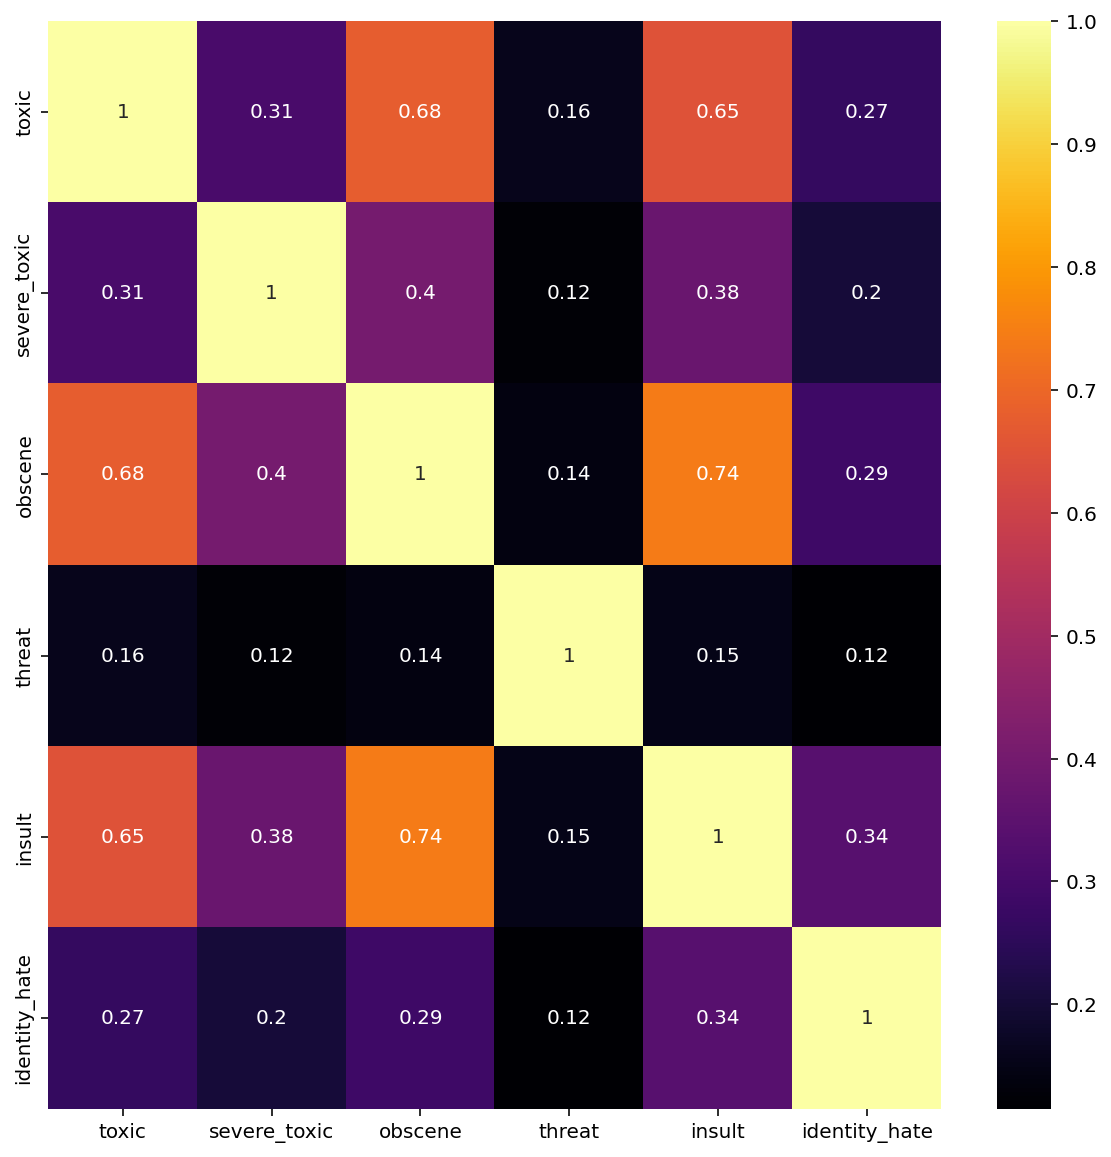

In [ ]:
# Visualise any correlations between labels:
# It seems there are some strong correlations between labels
heatmap_data = df[target_columns]
plt.figure(figsize=(10, 10))
ax = sns.heatmap(heatmap_data.corr(), cmap='inferno', annot=True)
ax.tick_params(labelsize=10)

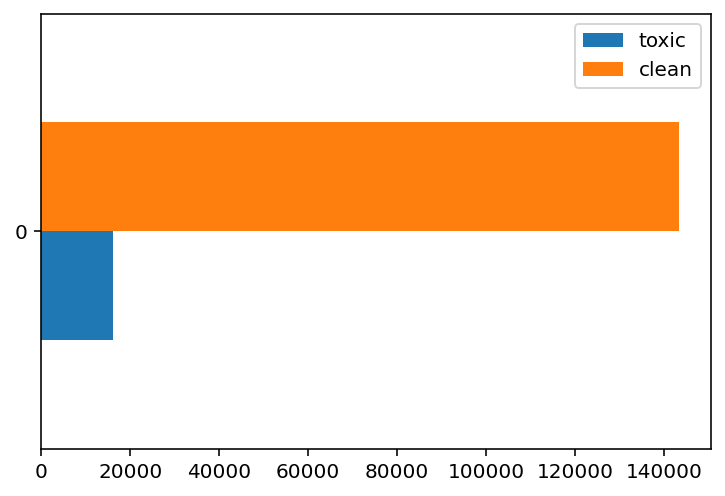

In [ ]:
LABEL_COLUMNS = df.columns.tolist()[1:]
df_toxic = df[df[LABEL_COLUMNS].sum(axis=1) > 0]
df_clean = df[df[LABEL_COLUMNS].sum(axis=1) == 0]

pd.DataFrame(dict(
  toxic=[len(df_toxic)], 
  clean=[len(df_clean)]
)).plot(kind='barh');

In [ ]:
df_clean

,text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [ ]:
df_clean=df_clean[:8000]

In [ ]:
df_clean

,text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...
8929,"""\nThis isn't """"based off of"""" a Cure song. So...",0,0,0,0,0,0
8930,and the largest - the 1996 swing was smaller t...,0,0,0,0,0,0
8931,November 2008 \n\nThank you for experimenting ...,0,0,0,0,0,0
8932,"Many thanks, Jack. So soothing and refreshing!",0,0,0,0,0,0


In [ ]:
df_toxic=df_toxic[:8000]

In [ ]:
# df=pd.concat([df, df_clean, df_clean]).drop_duplicates(keep=False)

In [ ]:
df = df_toxic.append(df_clean, ignore_index=True)

In [ ]:
df['text']=df['text'].apply(lambda x: preprocess(x))
df

,text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,cocksucker piss around work,1,1,1,0,1,0
1,hey talk exclusive group wp talibanswho good d...,1,0,0,0,0,0
2,bye look come think comming back tosser,1,0,0,0,0,0
3,gay antisemmitian archangel white tiger meow g...,1,0,1,0,1,1
4,fuck filthy mother as dry,1,0,1,0,1,0
...,...,...,...,...,...,...,...
15995,based cure song sometimes band compared stylis...,0,0,0,0,0,0
15996,largest swing smaller one three orderinchaos,0,0,0,0,0,0
15997,november thank experimenting wikipedia test wo...,0,0,0,0,0,0
15998,many thanks jack soothing refreshing,0,0,0,0,0,0


In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2,random_state=19)

In [ ]:
train

,text,toxic,severe_toxic,obscene,threat,insult,identity_hate
7189,sorry master say dog parent say child clearly ...,1,0,0,0,0,0
14089,episode summary require source guideline say m...,0,0,0,0,0,0
8938,comment reverted unable see worry found one us...,0,0,0,0,0,0
14170,somewhat similar rationale applies edwin hubbl...,0,0,0,0,0,0
13768,delete harry walther article worried deletion ...,0,0,0,0,0,0
...,...,...,...,...,...,...,...
5032,hello fucking freak mate get life get facelift...,1,0,1,0,1,0
1378,hey jac chickenshit take shot someone blocked ...,1,0,1,0,1,0
757,bothering man seperate singing raping little b...,1,0,1,0,1,0
10862,agree certainly agree last paragraph removed a...,0,0,0,0,0,0


In [ ]:
test

,text,toxic,severe_toxic,obscene,threat,insult,identity_hate
8622,see antisemitism guy give lecture new york syn...,0,0,0,0,0,0
249,usernhrhs homo like mitt romney usernhrhs homo...,1,0,1,0,1,1
13813,preceding unsigned comment added talk contribs,0,0,0,0,0,0
6649,everything zimmerman claimed backed fact idiot...,1,0,0,0,0,0
4002,fuck edited page well,1,0,1,0,0,0
...,...,...,...,...,...,...,...
1877,itnc go fuck,1,1,1,0,1,0
9939,please vandalise wikipedia find wikipediawhy w...,0,0,0,0,0,0
4757,utc hope right place write say consensus see t...,1,0,1,0,0,0
7956,cocksucker eskog reported jimbo wale blocking ...,1,0,1,0,0,0


In [ ]:
train.shape,test.shape

((12800, 7), (3200, 7))

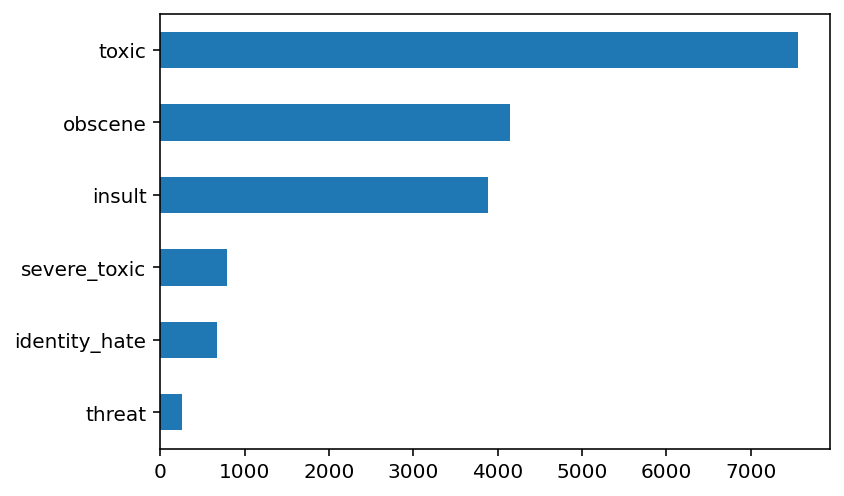

In [ ]:
LABEL_COLUMNS = df.columns.tolist()[1:]
df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


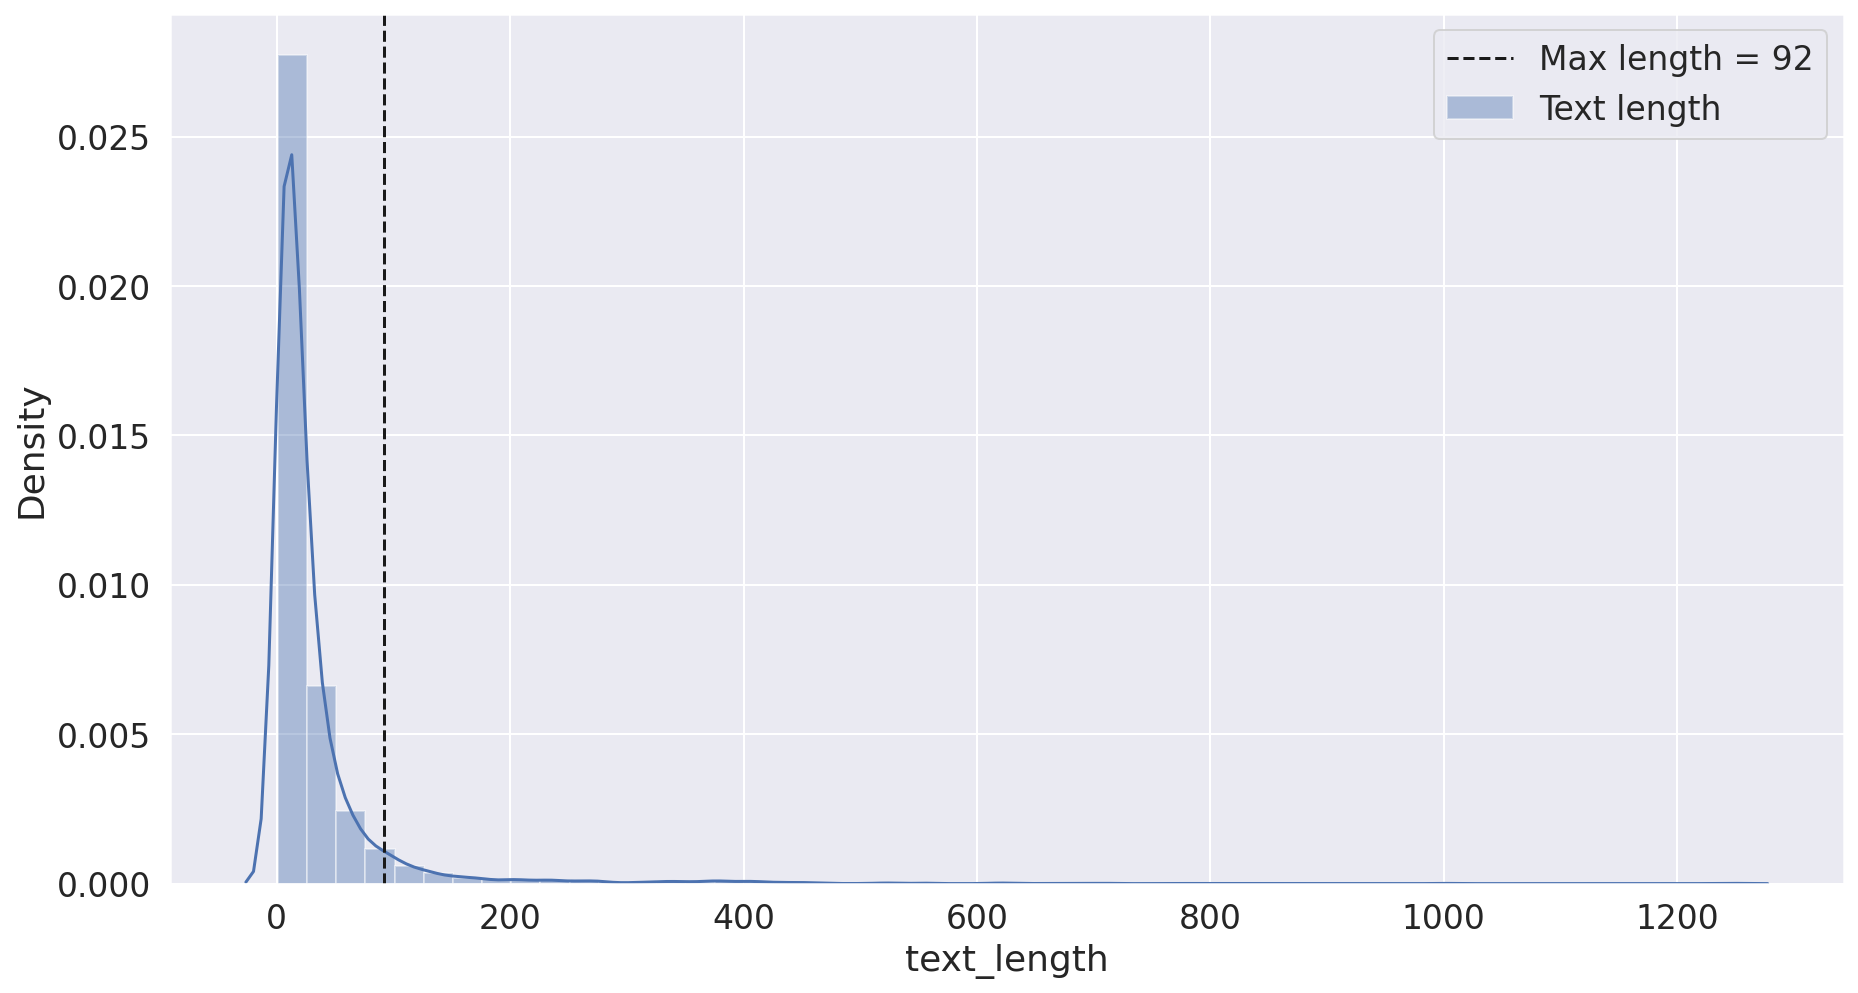

In [ ]:
train["text_length"] = train["text"].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train["text_length"].mean() + train["text_length"].std()).astype(int)

plt.figure(figsize=(15,8))
sns.set(font_scale = 1.5)
sns.distplot(train["text_length"], hist=True, kde=True, color='b', label='Text length')
label = 'Max length = {}'.format(max_seq_len)
plt.axvline(x=max_seq_len, color='k', linestyle='--', label=label)
plt.legend()
plt.show()

#free space
del train["text_length"]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


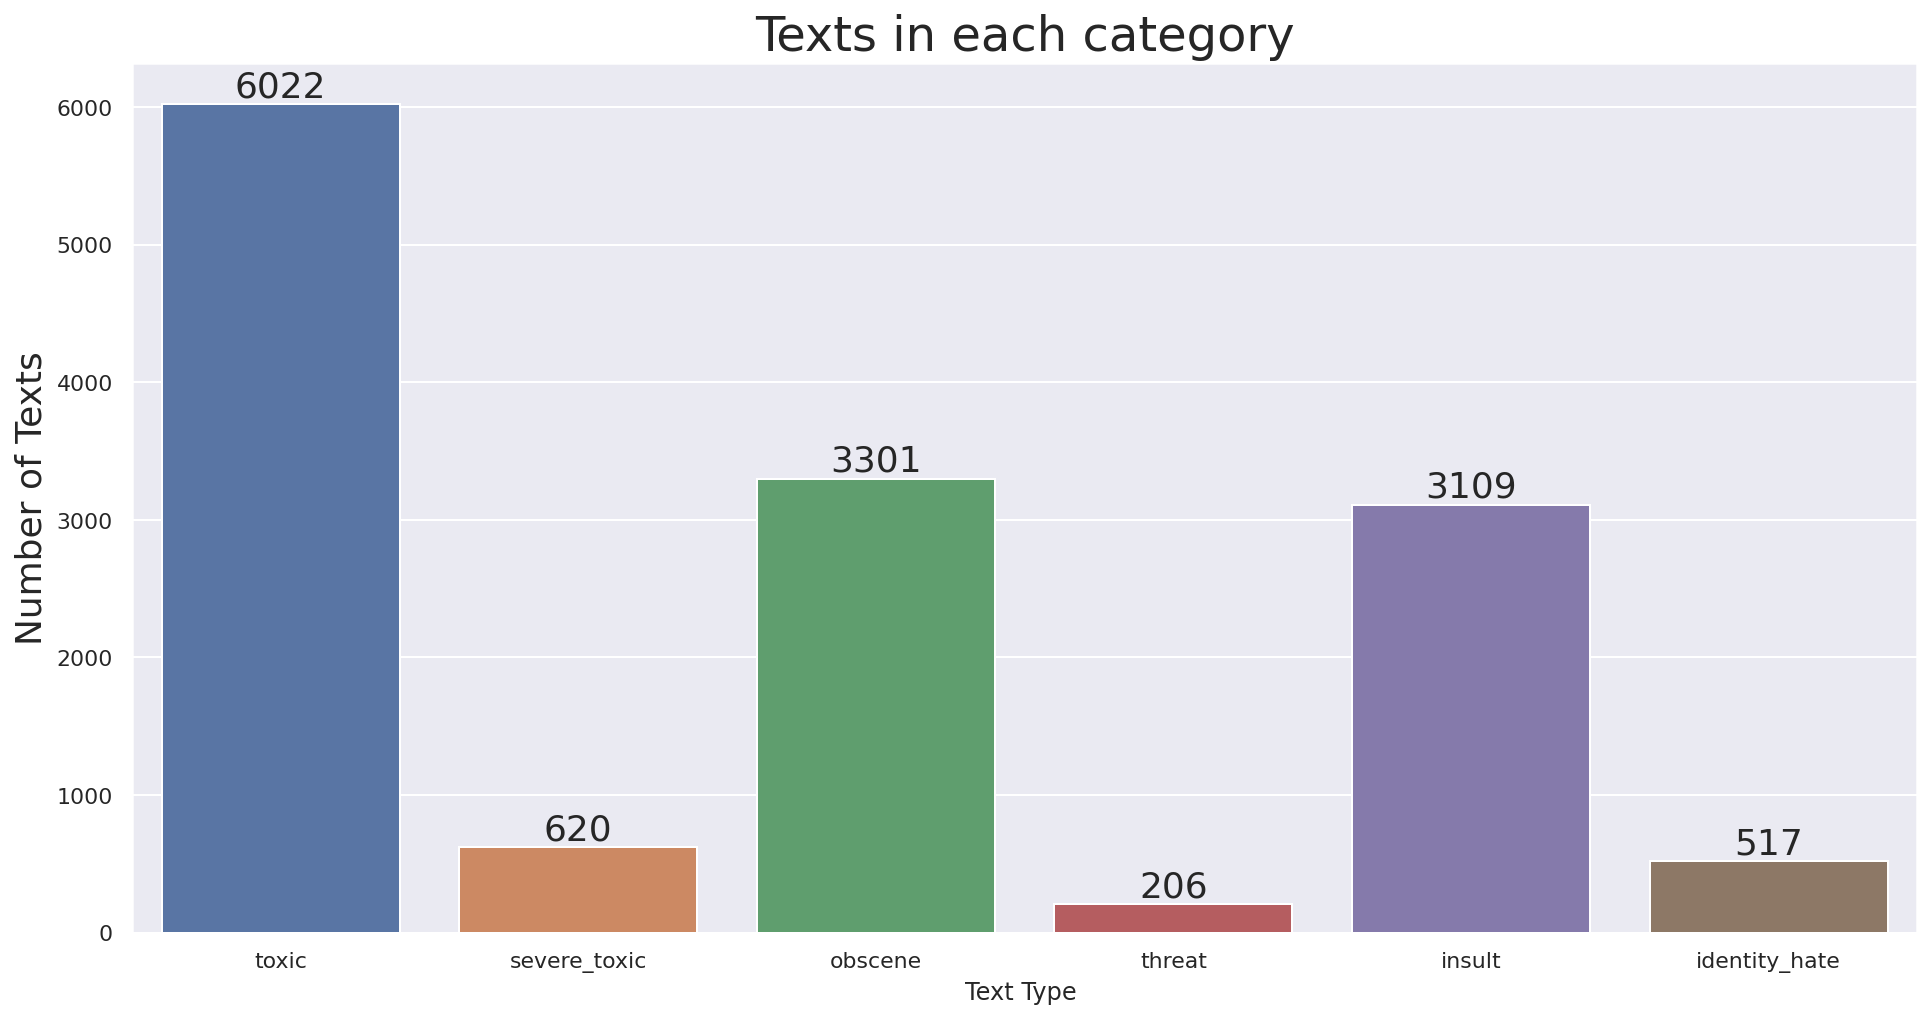

In [ ]:
list_classes = list(train.columns[1:].values)
num_classes = len(list_classes)
y_train = train[list_classes].to_numpy()
distrib_classes = train[list_classes].sum(axis=0)

#visualize classes distribution
plt.figure(figsize=(16,8))
sns.set(font_scale = 1.0)
ax= sns.barplot(list_classes, distrib_classes)

plt.title("Texts in each category", fontsize=24)
plt.ylabel('Number of Texts', fontsize=18)
plt.xlabel('Text Type ', fontsize=12)

#add the count above:
rects = ax.patches
for rect, distrib_classe in zip(rects, distrib_classes):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, distrib_classe, ha='center', va='bottom', fontsize=18)

plt.show()

In [ ]:
# train_toxic = train[train[LABEL_COLUMNS].sum(axis=1) > 0]
# train_clean = train[train[LABEL_COLUMNS].sum(axis=1) == 0]

# pd.DataFrame(dict(
#   toxic=[len(train_toxic)], 
#   clean=[len(train_clean)]
# )).plot(kind='barh');

In [ ]:
# train_clean

In [ ]:

# train_df = pd.concat([
#   train_toxic,
#   train_clean.sample(3)
# ])

# train_df.shape, test.shape

In [ ]:
# train_toxic = train[train[LABEL_COLUMNS].sum(axis=1) > 0]
# train_clean = train[train[LABEL_COLUMNS].sum(axis=1) == 0]

# pd.DataFrame(dict(
#   toxic=[len(train_toxic)], 
#   clean=[len(train_clean)]
# )).plot(kind='barh');

In [ ]:
# !pip install pytorch_lightning

In [ ]:
# !pip install transformers

In [ ]:
# import pandas as pd
# import numpy as np

# from tqdm.auto import tqdm

# import torch
# import torch.nn as nn
# from torch.utils.data import Dataset, DataLoader

# from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

# import pytorch_lightning as pl
# from torchmetrics.functional import accuracy, f1_score, auroc
# from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
# from pytorch_lightning.loggers import TensorBoardLogger

# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report, multilabel_confusion_matrix

# import seaborn as sns
# from pylab import rcParams
# import matplotlib.pyplot as plt
# from matplotlib import rc

# %matplotlib inline
# %config InlineBackend.figure_format='retina'

In [ ]:
RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

pl.seed_everything(RANDOM_SEED)

Global seed set to 42


42

In [ ]:
BERT_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
sample_row = df.iloc[16]
sample_comment = sample_row.text
sample_labels = sample_row[LABEL_COLUMNS]

print(sample_comment)
print()
print(sample_labels.to_dict())

unblock get lawyer blocking constitutional right free speech

{'toxic': 1, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}


In [ ]:
encoding = tokenizer.encode_plus(
  sample_comment,
  add_special_tokens=True,
  max_length=60,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
encoding

{'input_ids': tensor([[  101,  8362, 27467,  1243,  4545, 11016,  7950,  1268,  1714,  4055,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}

In [ ]:
encoding["input_ids"].squeeze()

tensor([  101,  8362, 27467,  1243,  4545, 11016,  7950,  1268,  1714,  4055,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])

In [ ]:
encoding["attention_mask"].squeeze()

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
encoding["input_ids"].shape, encoding["attention_mask"].shape

(torch.Size([1, 60]), torch.Size([1, 60]))

In [ ]:
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze()))

['[CLS]', 'un', '##block', 'get', 'lawyer', 'blocking', 'constitutional', 'right', 'free', 'speech', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [ ]:
token_counts = []

for _, row in train.iterrows():
  token_count = len(tokenizer.encode(
    row["text"], 
    max_length=512, 
    truncation=True
  ))
  token_counts.append(token_count)

(1.0, 512.0)

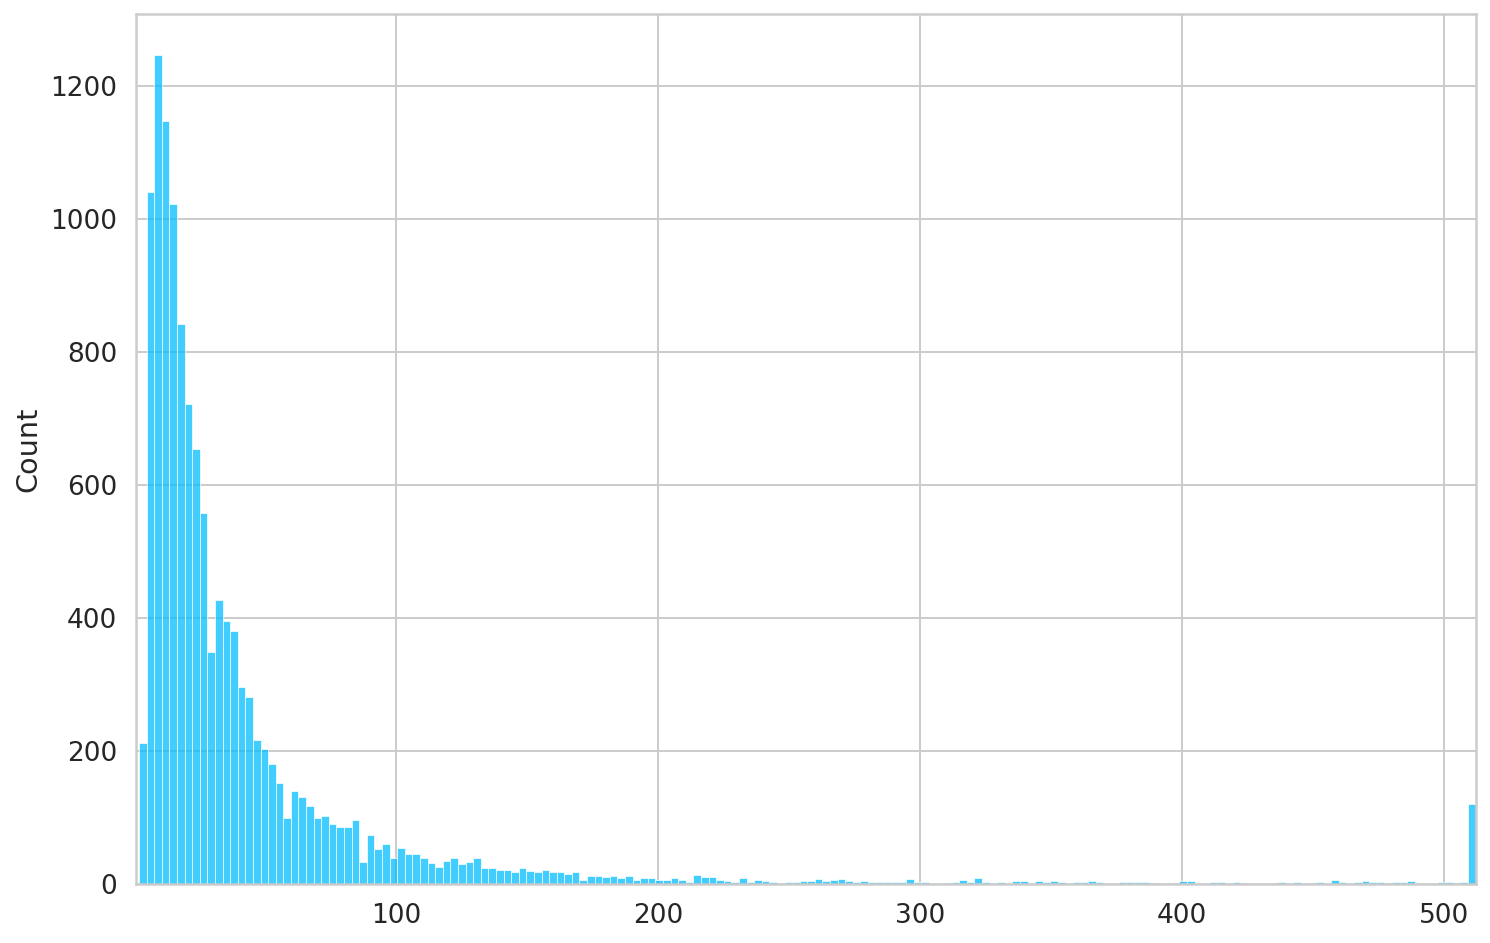

In [ ]:
sns.histplot(token_counts)
plt.xlim([1,512])

In [ ]:
MAX_TOKEN_COUNT = 100

In [ ]:
class ToxicCommentsDataset(Dataset):

  def __init__(
    self, 
    data: pd.DataFrame, 
    tokenizer: BertTokenizer, 
    max_token_len: int = 128
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len
    
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]

    text = data_row.text
    labels = data_row[LABEL_COLUMNS]

    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return dict(
      Text=text,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=np.asarray(labels)
    )

In [ ]:
train_dataset = ToxicCommentsDataset(
  train,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

train_dataset[0]

{'Text': 'sorry master say dog parent say child clearly illusion somehow important wikipedia bos mine since illusion likely thing keeping ending sorry life end subordinate hopefully make small penis sorry yes master anything say power must repent talk c',
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]),
 'input_ids': tensor([  101,  2959,  3283,  1474,  3676,  6486,  1474,  2027,  3817, 14488,
          5006,  1696,   192, 12635,  3537,  1465,   171,  2155,  2317,  1290,
         14488,  2620,  1645,  3709,  3830,  2959,  1297,  1322, 16469, 16121,
          1294,  1353, 21504,  2959,  4208,  3283,  1625,  1474,  1540,  1538,
          1231, 22083,  2037,   172,   102,     0,

In [ ]:
test_dataset=ToxicCommentsDataset(
    test,
    tokenizer,
    max_token_len=MAX_TOKEN_COUNT
)
test_dataset[0]

{'Text': 'see antisemitism guy give lecture new york synagogue knock country every single minute using every opportunity influential newspaper new york post one state interest personal find intellectual person among neoconservative new york post michelle malkin andrea peyser deborah orin may rest peace although know rotting helland essayist one make great company amir taheri guy mind agree iran regime wrong regime shah amir taheri longing owned keyhan regime better islamic revolution justified look intriduce amir taheri article new york post based europe memeber benador associate europe small small town say based world journalist may breakfast london christian amanpour james rubin eating lunch jerusalem lecture dinner anti irani jew forest hill new york emailing full hatred article new york post stupid saysomebody based europe asia africa',
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
train_dataset[0]['labels']

array([1, 0, 0, 0, 0, 0], dtype=object)

In [ ]:
train_input_id_tensors,train_attention_mask_tensor,y_train=[],[],[]
for ind in range(len(train)):
  sample_data=train_dataset[ind]
  train_input_id_tensors.append(sample_data['input_ids'])
  train_attention_mask_tensor.append(sample_data['attention_mask'])
  y_train.append(sample_data['labels'])
  # print(ind)
  # print('Input Id: ',sample_data['input_ids'])
  # print('Attentionmask: ',sample_data['attention_mask'])
  # print('\n====================================\n')
train_input_id_tensors = torch.Tensor([t.size() for t in train_input_id_tensors]).to(torch.int64)
train_attention_mask_tensor=torch.Tensor([t.size() for t in train_attention_mask_tensor]).to(torch.int64)
# y_train=torch.Tensor([t.size() for t in y_train]).to(torch.int64)

In [ ]:
test_input_id_tensors,test_attention_mask_tensor,y_test=[],[],[]
for ind in range(len(test)):
  sample_data=test_dataset[ind]
  test_input_id_tensors.append(sample_data['input_ids'])
  test_attention_mask_tensor.append(sample_data['attention_mask'])
  y_test.append(sample_data['labels'])
  # print(ind)
  # print('Input Id: ',sample_data['input_ids'])
  # print('Attentionmask: ',sample_data['attention_mask'])
  # print('\n====================================\n')
test_input_id_tensors = torch.Tensor([t.size() for t in test_input_id_tensors]).to(torch.int64)
test_attention_mask_tensor=torch.Tensor([t.size() for t in test_attention_mask_tensor]).to(torch.int64)
# y_test=torch.Tensor([t.size() for t in y_test]).to(torch.int64)

In [ ]:
y_train[:5]

In [ ]:
# import tensorflow as tf

In [ ]:
# type(train_input_id_tensors)

In [ ]:
# import torch

In [ ]:
# input_id_tensors = torch.Tensor([t.size() for t in input_id_tensors]).to(torch.int64)
# attention_mask_tensor=torch.Tensor([t.size() for t in attention_mask_tensor]).to(torch.int64)


In [ ]:
bert_model = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# input_id_tensors.shape,attention_mask_tensor.shape

In [ ]:
# type(input_id_tensors)

In [ ]:
# sample_batch = next(iter(DataLoader(train_dataset, batch_size=10, num_workers=2)))
# sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape

In [ ]:
x_train = bert_model(train_input_id_tensors, train_attention_mask_tensor)

In [ ]:
x_test = bert_model(test_input_id_tensors, test_attention_mask_tensor)

In [ ]:

x_train=x_train[0][:,0,:].detach().numpy().astype('float32')
x_test=x_test[0][:,0,:].detach().numpy().astype('float32')
y_train=np.asarray(y_train).astype('float32')
y_test=np.asarray(y_test).astype('float32')

In [ ]:
x_train[:5]

array([[ 0.04111378, -0.3533376 ,  0.27209476, ..., -0.07853311,
         0.00537459,  0.7833747 ],
       [ 0.04111378, -0.3533376 ,  0.27209476, ..., -0.07853311,
         0.00537459,  0.7833747 ],
       [ 0.04111378, -0.3533376 ,  0.27209476, ..., -0.07853311,
         0.00537459,  0.7833747 ],
       [ 0.04111378, -0.3533376 ,  0.27209476, ..., -0.07853311,
         0.00537459,  0.7833747 ],
       [ 0.04111378, -0.3533376 ,  0.27209476, ..., -0.07853311,
         0.00537459,  0.7833747 ]], dtype=float32)

In [ ]:
y_train[:5]

array([[1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
x_train.shape

(12800, 768)

In [ ]:
type(x_train)

numpy.ndarray

In [ ]:
y_train.shape

(12800, 6)

In [ ]:
type(y_train)

numpy.ndarray

In [ ]:
x_test.shape

(3200, 768)

In [ ]:
type(x_test)

numpy.ndarray

In [ ]:
y_test.shape

(3200, 6)

In [ ]:
type(y_test)

numpy.ndarray

In [ ]:
x_train=np.reshape(x_train,(12800,-1,768))
x_test=np.reshape(x_test,(3200,-1,768))

In [ ]:
# x_train[0].shape

In [ ]:
# x_train[0][0].shape

In [ ]:
# type(x_train[0])

In [ ]:
# x_train.last_hidden_state.shape, x_train.pooler_output.shape

In [ ]:
# x_test[0]

In [ ]:
# y_train=np.asarray(y_train)
# y_test=np.asarray(y_test)
# y_train = tf.convert_to_tensor(y_train)
# y_test=tf.convert_to_tensor(y_test)

In [ ]:
# y_train

In [ ]:
# type(y_train)

In [ ]:
# x_test[0]

In [ ]:
# type(x_test)

In [ ]:
# x_test.last_hidden_state.shape, x_test.pooler_output.shape

In [ ]:
# y_train.shape

In [ ]:
# y_test.shape

In [ ]:
bert_model.config.hidden_size

768

In [ ]:
# df.head()

In [ ]:
# pip install scikit-multilearn

In [ ]:
# lengthed=[]
# for i in df['text']:
#   lengthed.append(len(i.split(" ")))

# print(max(lengthed))


In [ ]:
# len(df['text'][0].split(' '))

In [ ]:
import numpy as np
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

In [ ]:
model = Sequential()
model.add(LSTM(256,input_dim=768,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(6, activation='sigmoid'))



In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               1049600   
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
Total params: 1,091,142
Trainable params: 1,091,142
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
model.fit(x_train,y_train,epochs=10,validation_data=(x_test,y_test))

Epoch 1/10
400/400 [==============================] - 5s 5ms/step - loss: 12.1347 - accuracy: 0.5620 - val_loss: 40.7190 - val_accuracy: 0.0091
Epoch 2/10
400/400 [==============================] - 2s 4ms/step - loss: 201.2271 - accuracy: 0.4462 - val_loss: 489.0610 - val_accuracy: 0.9731
Epoch 3/10
400/400 [==============================] - 2s 4ms/step - loss: 872.4913 - accuracy: 0.4409 - val_loss: 1397.0415 - val_accuracy: 0.0091
Epoch 4/10
400/400 [==============================] - 2s 4ms/step - loss: 2188.5884 - accuracy: 0.4445 - val_loss: 3882.1091 - val_accuracy: 0.0000e+00
Epoch 5/10
400/400 [==============================] - 2s 5ms/step - loss: 5841.6748 - accuracy: 0.4477 - val_loss: 9697.5371 - val_accuracy: 0.0000e+00
Epoch 6/10
400/400 [==============================] - 2s 4ms/step - loss: 9029.3926 - accuracy: 0.4427 - val_loss: 8812.8193 - val_accuracy: 0.0159
Epoch 7/10
400/400 [==============================] - 2s 4ms/step - loss: 16751.7031 - accuracy: 0.4449 - val_l

In [ ]:
#Saving the model
model_json=model.to_json()
with open("kaggle_dataset_model2.json","w") as json_file:
    json_file.write(model_json)
    #serializing weights to HDF5
model.save_weights("kaggle_dataset_model2.h5")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
a='Bharadwaj is a verified asshole.'
a=preprocess(a)
a


'bharadwaj verified asshole'

In [ ]:
encoding = tokenizer.encode_plus(
  a,
  add_special_tokens=True,
  max_length=100,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
encoding

{'input_ids': tensor([[  101,   171, 10131,  1181,  3624,  3361, 22480, 27877,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0

In [ ]:
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze()))

['[CLS]', 'b', '##hara', '##d', '##wa', '##j', 'verified', 'asshole', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [ ]:
test_text = bert_model(encoding['input_ids'], encoding['attention_mask'])

In [ ]:
# test_text

In [ ]:
test_text=test_text[0][:,0,:].detach().numpy().astype('float32')

In [ ]:
test_text.shape


(1, 768)

In [ ]:
test_text=np.reshape(test_text,(1,-1,768))

In [ ]:
test_text.shape


(1, 1, 768)

In [ ]:
model.predict(test_text)

array([[1., 1., 1., 1., 1., 1.]], dtype=float32)

## **Testing**

In [ ]:
!pip install contractions
!pip install datasets
!pip install pytorch_lightning
!pip install transformers

import tensorflow as tf
import torch

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

import pandas as pd
import numpy as np
import re
import string
import math
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download("stopwords")
nltk.download("wordnet")

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from torchmetrics.functional import accuracy, f1_score, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

from pylab import rcParams
from matplotlib import rc
import seaborn as sns
import matplotlib.pyplot as plt
import os



%matplotlib inline
%config InlineBackend.figure_format='retina'

In [ ]:



bert_model = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
def test(text,loaded_model):
  text=preprocess(text)
  encoding = tokenizer.encode_plus(
  text,
  add_special_tokens=True,
  max_length=100,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt', )
  text = bert_model(encoding['input_ids'], encoding['attention_mask'])
  text=text[0][:,0,:].detach().numpy().astype('float32')
  text=np.reshape(text,(1,-1,768))
  return(list(loaded_model.predict(text)))


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
text="Yo bitch Ja Rule is more succesful then you'll ever be whats up with you and hating you sad mofuckas...i should bitch slap ur pethedic white faces and get you to kiss my ass you guys sicken me. Ja rule is about pride in da music man. dont diss that shit on him. and nothin is wrong bein like tupac he was a brother too...fuckin white boys get things right next time.,"
test(text,model)

[array([1., 1., 1., 1., 1., 1.], dtype=float32)]

In [ ]:
text="Dear god this site is horrible."
test(text,model)

[array([1., 1., 1., 1., 1., 1.], dtype=float32)]

In [ ]:
text=df['text'][]
text


KeyError: ignored

In [ ]:
test(text,model)

In [ ]:
text="good boy"
test(text,model)